# Predicting House Sale Prices

This project uses a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

You can read more about it [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627)

You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt)

## Introduction

In [22]:
# import all the libraries needed

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score


In [2]:
# read the data

data = pd.read_csv('AmesHousing.tsv', delimiter = '\t')

In [3]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
#create functions needed

def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    lr = LinearRegression()
    num_cols = df.select_dtypes(include = ['int', 'float']).columns
    num_cols = num_cols.drop('SalePrice')
    
    lr.fit(train[num_cols], train['SalePrice'])
    predictions = lr.predict(test[num_cols])
    
    MSE = mean_squared_error(test['SalePrice'], predictions)
    
    RMSE = np.sqrt(MSE)
      
    return RMSE

#only do it for Gr Liv Area now
transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

57088.25161263909

## Feature Engineering

#### Handle missing values:
    1. All columns:
            Drop any with 5% or more missing values
    2. Numerical columns:
            For columns with missing values, fill in with the most common value in that column

In [5]:
def transform_features(data):  
    
    #remove columns that have too many missing values
    data.drop(labels= ['Alley', 'Fireplace Qu','Pool QC', 'Fence', 'Misc Feature'], axis = 1, inplace = True)
    
    ## Drop columns that aren't useful for ML
    data = data.drop(["PID", "Order"], axis=1)
    data = data.drop(["Sale Condition", "Sale Type"], axis=1)
    
    num_data = data.select_dtypes(include = ['int', 'float'])
    cat_data = data.select_dtypes(exclude = ['int', 'float'])
    
    ##categorical data
    #replace other columns with most common values
    data['Mas Vnr Type'] = cat_data['Mas Vnr Type'].replace(np.nan, 'None')
    data['Bsmt Qual'] = cat_data['Bsmt Qual'].replace(np.nan, 'TA')
    data['Bsmt Cond'] = cat_data['Bsmt Cond'].replace(np.nan, 'TA')
    data['Bsmt Exposure'] = cat_data['Bsmt Exposure'].replace(np.nan, 'No')
    data['BsmtFin Type 1'] = cat_data['BsmtFin Type 1'].replace(np.nan, 'GLQ')
    data['BsmtFin Type 2'] = cat_data['BsmtFin Type 2'].replace(np.nan, 'Unf')
    data['Electrical'] = cat_data['Electrical'].replace(np.nan, 'SBrkr')
    data['Garage Type'] = cat_data['Garage Type'].replace(np.nan, 'Attchd')
    data['Garage Finish'] = cat_data['Garage Finish'].replace(np.nan, 'Unf')
    data['Garage Qual'] = cat_data['Garage Qual'].replace(np.nan, 'TA')
    data['Garage Cond'] = cat_data['Garage Cond'].replace(np.nan, 'TA')
    
    ##transform them to categorical data
#     for col in cat_data.columns:
#         data[col]= data[col].astype('category')
    
#     ## fill it with dummy values instead of categories
#     for col in cat_data.columns:
#         dummy = pd.get_dummies(data[col])
#         data = pd.concat([data, dummy], axis = 1)
#         del data[col]
        
        
    ##numerical data
    data_nulls = data.isnull().sum()
    
    #drop values that have more than 300 missing 
    data[data_nulls[(data_nulls > 300)].index] = data[data_nulls[(data_nulls > 300)].index].dropna()
    
    #replace other values with average value    
    for col in num_data.columns:
        data[col] = data[col].fillna(data[col].mean())
    
    ## Create new columns
    years_sold = data['Yr Sold'] - data['Year Built']
    years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    
    data['Years Before Sale'] = years_sold
    data['Years Since Remod'] = years_since_remod

    ## Drop rows with negative values for both of these new features
    data = data.drop([1702, 2180, 2181], axis=0)

    ## No longer need original year columns
    data = data.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
     
    ## Drop columns that leak info about the final sale
    data = data.drop(["Mo Sold", "Yr Sold"], axis=1)    
    
    return data

In [6]:
data = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse


55275.367312413066

In [7]:
transform_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 71 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2927 non-null   int64  
 1   MS Zoning          2927 non-null   object 
 2   Lot Frontage       2927 non-null   float64
 3   Lot Area           2927 non-null   int64  
 4   Street             2927 non-null   object 
 5   Lot Shape          2927 non-null   object 
 6   Land Contour       2927 non-null   object 
 7   Utilities          2927 non-null   object 
 8   Lot Config         2927 non-null   object 
 9   Land Slope         2927 non-null   object 
 10  Neighborhood       2927 non-null   object 
 11  Condition 1        2927 non-null   object 
 12  Condition 2        2927 non-null   object 
 13  Bldg Type          2927 non-null   object 
 14  House Style        2927 non-null   object 
 15  Overall Qual       2927 non-null   int64  
 16  Overall Cond       2927 

## Feature Selection

In [8]:
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
numerical_df.head(5)

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,141.0,31770,6,5,112.0,639.0,0.0,441.0,1080.0,...,210,62,0,0,0,0,0,215000,50,50
1,20,80.0,11622,5,6,0.0,468.0,144.0,270.0,882.0,...,140,0,0,0,120,0,0,105000,49,49
2,20,81.0,14267,6,6,108.0,923.0,0.0,406.0,1329.0,...,393,36,0,0,0,0,12500,172000,52,52
3,20,93.0,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,...,0,0,0,0,0,0,0,244000,42,42
4,60,74.0,13830,5,5,0.0,791.0,0.0,137.0,928.0,...,212,34,0,0,0,0,0,189900,13,12


### Correlation heatmap

In [9]:
#correlating according to Sale Price
corrs = numerical_df.corr()['SalePrice'].abs().sort_values()
corrs

BsmtFin SF 2         0.006000
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035874
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182248
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276329
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
Lot Frontage         0.341151
BsmtFin SF 1         0.438928
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.510611
Garage Yr Blt        0.510703
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641675
Total Bsmt SF        0.643601
Garage Cars          0.648411
Gr Liv Area          0.717596
Overall Qu

In [10]:
## Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary, worth experimenting later!)
strong_corrs = corrs[corrs > 0.4]
strong_corrs

BsmtFin SF 1         0.438928
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.510611
Garage Yr Blt        0.510703
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641675
Total Bsmt SF        0.643601
Garage Cars          0.648411
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

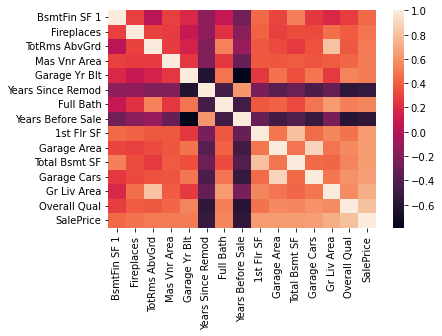

In [11]:
corrmat = numerical_df[strong_corrs.index].corr() 

#displaying heatmap
sns.heatmap(corrmat)

We can see them 'YEars Since Remod' and 'YEars Before Sale' have high Colinearity. We can remove one of them.

In [12]:
## Drop columns with less than 0.4 correlation with SalePrice
transform_df = transform_df.drop(corrs[corrs < 0.4].index, axis=1)

## drop 'Years Before Sale'
transform_df = transform_df.drop(['Years Before Sale'], axis=1)


### Update select features

In [13]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    cat_df = df.select_dtypes(exclude = ['int', 'float'])
    
    ## How many unique values in each categorical column?
    uniqueness_counts = cat_df.apply(lambda col: len(col.value_counts())).sort_values()
    
    ## Aribtrary cutoff of 10 unique values (worth experimenting)
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > uniq_threshold].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    ##transform them to categorical data
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col]= df[col].astype('category')
        
    ## fill with dummy values
    #df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
        ## fill it with dummy values instead of categories
    for col in text_cols:
        dummy = pd.get_dummies(df[col])
        df = pd.concat([df, dummy], axis = 1)
        del df[col]

    return df

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    lr = LinearRegression()
#     num_cols = df.select_dtypes(include = ['int', 'float']).columns
#     num_cols = num_cols.drop('SalePrice')
    
    cols = df.columns
    cols = cols.drop('SalePrice')
    
    lr.fit(train[cols], train['SalePrice'])
    predictions = lr.predict(test[cols])
    
    MSE = mean_squared_error(test['SalePrice'], predictions)
    
    RMSE = np.sqrt(MSE)
      
    return RMSE

In [14]:
data = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

32527.71353125153

## Training and Testing

update train_and_test function to include value k for KFold cross-validation


In [65]:

def train_and_test(df, k=0):
    
    if k == 0: 
        train = df[:1460]
        test = df[1460:]

        lr = LinearRegression()    
        cols = df.columns
        cols = cols.drop('SalePrice')

        lr.fit(train[cols], train['SalePrice'])
        predictions = lr.predict(test[cols])

        MSE = mean_squared_error(test['SalePrice'], predictions)

        RMSE = np.sqrt(MSE)
    
    elif k == 1:
        
        shuffled_index = np.random.permutation(df.index)
        rand_df = df.reindex(shuffled_index)
        
        fold_one = rand_df[:1460]
        fold_two = rand_df[1460:]

        lr = LinearRegression()    
        cols = df.columns
        cols = cols.drop('SalePrice')

        lr.fit(fold_one[cols], fold_one['SalePrice'])
        predictions_one = lr.predict(fold_two[cols])
        
        lr.fit(fold_two[cols], fold_two['SalePrice'])
        predictions_two = lr.predict(fold_one[cols])

        MSE_one = mean_squared_error(fold_two['SalePrice'], predictions_one)

        MSE_two = mean_squared_error(fold_one['SalePrice'], predictions_two)

        RMSE = np.mean([np.sqrt(MSE_one), np.sqrt(MSE_one)])       
        
    else:
        
        lr = LinearRegression()    
        cols = df.columns
        cols = cols.drop('SalePrice')
        
        Kf = KFold(k, shuffle = True)
        
        MSES = cross_val_score(lr, df[cols], df['SalePrice'], scoring="neg_mean_squared_error", cv = Kf)
        RMSES = np.sqrt(np.absolute(MSES))
        
        RMSE = np.mean(RMSES)   
      
    return RMSE

In [76]:
data = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transform_df = transform_features(data)
filtered_df = select_features(transform_df)

for i in range(10):
    rmse = train_and_test(filtered_df, i)
    print ("{} : {}".format(i, rmse))


0 : 32527.71353125153
1 : 26068.66506252586
2 : 28454.68846959622
3 : 27962.697970704205
4 : 27893.895074382228
5 : 27352.90003021794
6 : 27271.42156303985
7 : 27126.449398601886
8 : 27508.563058957086
9 : 27142.860582192647
